In [21]:
import pandas as pd
import re
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from gensim.models import ldamodel
import gensim.corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
import re
from nltk import pos_tag,word_tokenize

#preprocess description category from the dataset
def preprocess(x):
    st = stopwords.words('english')
    ps = PorterStemmer()
    x = re.sub('[^A-z\s]+|the','',str(x))
    x = ' '.join([(word.lower()) for word in x.split() if word.strip().lower() not in st and len(word)>2]) #ps.stem   
    text = word_tokenize(x)
    p_tag = pos_tag(text)
    x = [i[0] for i in p_tag if i[1].startswith(('N'))]
    return ' '.join(x)

#pick out the pincodes from the location column
def find_code(x):
    lis = re.findall('[0-9]+',str(x))
    if len(lis) > 0:
        return lis[0]
    else:
        return ''

#pick out states from location column
def find_state(x):
    if re.findall('.[A-Z][A-Z].',str(x)):
        return re.findall('.[A-Z][A-Z].',str(x))[0]
    else:
        return ''

# Map designations to the ones present in the bag of words
def condense(x):
    bow = ['Data Scientist','Data Analyst','Data Engineer','Research Scientist','Manager',
           'Software Engineer','Research Analyst','Research Associate', 'Business Analyst',
          'Senior Analyst','Web Developer','System Engineer','Project Analyst','Developer','Analytics Consultant',
          'Clinical Scientist','Development','Director','Manager','Engineer','Field Application Scientist',
           'VP','Vice President','Technician','Research Assistant','Intern','Finance',
           'Data Science','Deep learning','Digital marketing','Machine Learning','Business Intelligence',
           'Associate Scientist','Product','Research', 'Scientist',
           'Applied Scientist','Principal Scientist','Quantitative Analyst']
    for i in bow:
        if i.lower() in x.lower():
            return i
    return x

# Retrieve state abbreviations from location column
def secondstate(x):
    if not x[-2:].isnumeric():
        return x[-2:]
    else:
        return ''

# Define Generic position names based on condensed position
def change(x):
    if x == 'Scientist' or x == 'Research':
        return 'Research Scientist'
    if x == 'Engineer':
        return 'Software Engineer'
    if x == 'Data Science':
        return 'Data Scientist'
    if x == 'Manager':
        return 'Manager - Data Science'
    if x == 'Product' or x == 'Development':
        return 'Software Developer'
    if x == 'Machine Learning':
        return 'Machine Learning Engineer'
    else:
        return x

In [51]:
df = pd.read_csv('raw_data.csv')

In [52]:
df.head(10)

,position,company,description,reviews,location
0,Development Director,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301"
1,An Ostentatiously-Excitable Principal Research...,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA"
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA"
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303"
4,Assistant Professor -TT - Signal Processing & ...,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA"
5,Manager of Data Engineering,McKinsey & Company,Qualifications\nBachelor’s degree in Computer ...,385.0,"Atlanta, GA 30318"
6,"Product Specialist - Periscope, New Ventures",McKinsey & Company,Qualifications\nBachelor’s degree\n5-7 years o...,385.0,"Atlanta, GA 30318"
7,"Junior to Mid-level Engineer, Geologist or Env...",Wood,Overview / Responsibilities\nWood Environment ...,899.0,"Atlanta, GA"
8,Analyst - CIB Credit Research,SunTrust,Works closely with senior CIB professionals. P...,3343.0,"Atlanta, GA"
9,Senior Associate - Cognitive Data Scientist Na...,KPMG,Known for being a great place to work and buil...,4494.0,"Atlanta, GA 30338"


In [25]:
df['reviews'].describe()

count      5326.000000
mean       3179.089185
std        8448.515056
min           2.000000
25%          27.000000
50%         230.000000
75%        1578.000000
max      148114.000000
Name: reviews, dtype: float64

In [26]:
#extract city, state code and postal code from location
df['City'] = ''
df['State code'] = ''
df['Postal code'] = ''
df['City'] = list(map(lambda x: str(x).split(',')[0] if x else '',df['location']))
df['State code'] = list(map(lambda x: find_state(x) , df['location']))
df['Postal code'] = list(map(lambda x: find_code(x) , df['location']))

In [27]:
type(df['location'][0])

str

In [29]:
df.shape

(6964, 8)

In [30]:
#number of NA's - columnwise
df.isna().sum()

position         11
company          11
description      11
reviews        1638
location         11
City              0
State code        0
Postal code       0
dtype: int64

In [31]:
#drop records where position is missing as they are irrelevant
modDf = df.dropna(how='any', subset=['position'])

In [32]:
#modDf.shape

(6953, 8)

In [33]:
modDf['pos'] = list(map(lambda x: condense(x), modDf['position']))

C:\Users\palan\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [34]:
len(modDf.pos.unique())

965

In [35]:
modDf['State code 2'] = list(map(lambda x: secondstate(x),modDf['location']))

C:\Users\palan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [53]:
mylist = list(modDf['position'].value_counts()[:25].index)

In [54]:
mdf = modDf[modDf['position'].isin(mylist)]

In [55]:
mdf['position'] = list(map(lambda x: change(x), mdf['position']))
#mdf is exported as 'cleaned_dataset.csv' for ease of execution

C:\Users\palan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
#cleaned dataset
df = pd.read_csv('cleaned_dataset.csv') 
df.head(10)

,Position,Company,Description,Reviews,Location,City,State Code,Postal code
0,Software Developer,ALS TDI,Development Director\nALS Therapy Development ...,NaN,"Atlanta, GA 30301",Atlanta,GA,30301.0
1,Research Assistant,The Hexagon Lavish,"Job Description\n\n""The road that leads to acc...",NaN,"Atlanta, GA",Atlanta,GA,NaN
2,Data Scientist,Xpert Staffing,"Growing company located in the Atlanta, GA are...",NaN,"Atlanta, GA",Atlanta,GA,NaN
3,Data Analyst,Operation HOPE,DEPARTMENT: Program OperationsPOSITION LOCATIO...,44.0,"Atlanta, GA 30303",Atlanta,GA,30303.0
4,Machine Learning Engineer,Emory University,DESCRIPTION\nThe Emory University Department o...,550.0,"Atlanta, GA",Atlanta,GA,NaN
5,Data Engineer,McKinsey & Company,Qualifications\nBachelor’s degree in Computer ...,385.0,"Atlanta, GA 30318",Atlanta,GA,30318.0
6,Software Developer,McKinsey & Company,Qualifications\nBachelor’s degree\n5-7 years o...,385.0,"Atlanta, GA 30318",Atlanta,GA,30318.0
7,Software Engineer,Wood,Overview / Responsibilities\nWood Environment ...,899.0,"Atlanta, GA",Atlanta,GA,NaN
8,Research Scientist,SunTrust,Works closely with senior CIB professionals. P...,3343.0,"Atlanta, GA",Atlanta,GA,NaN
9,Data Scientist,KPMG,Known for being a great place to work and buil...,4494.0,"Atlanta, GA 30338",Atlanta,GA,30338.0


In [45]:
cloud = df[df['Position'].isin(['Machine Learning Engineer'])]

In [46]:
#preprocess text from decription
rwords = (preprocess(' '.join(list(cloud['Description'])))).split()

In [47]:
pd.Series(rwords).value_counts().head()

machine       665
experience    607
data          498
research      273
team          254
dtype: int64

In [48]:
mylist = list(df['Position'].unique())

In [49]:
mylist

['Software Developer',
 'Research Assistant',
 'Data Scientist',
 'Data Analyst',
 'Machine Learning Engineer',
 'Data Engineer',
 'Software Engineer',
 'Research Scientist',
 'Developer',
 'Manager - Data Science',
 'VP',
 'Quantitative Analyst',
 'Research Analyst',
 'Director',
 'Associate Scientist',
 'Intern',
 'Technician',
 'Senior Analyst',
 'Research Associate',
 'Business Analyst']

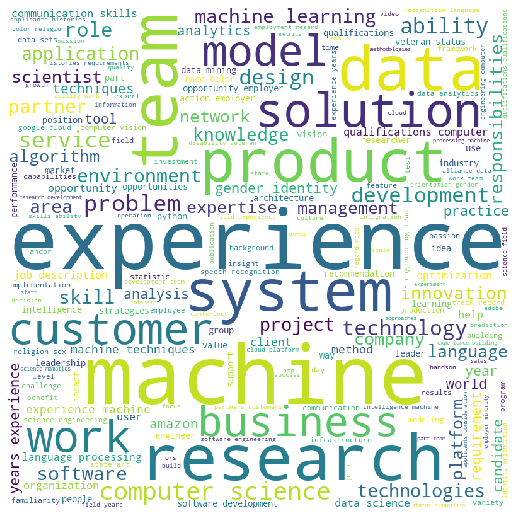

In [50]:
data = df[df['Position'] == mylist[4]]

col = 'Description'
data_text = data[col]

st  = stopwords.words('english')
st = [str(i) for i in st]
exception = ['ad']

ps = PorterStemmer()
d= data_text.apply(lambda x: preprocess(x))
#Visualize TF
var = []
for i in range(len(d)):
    var+= d.iloc[i].split()
corpus = Counter(var)
comment_words = ' '
for words in var:
    comment_words = comment_words + words + ' '
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 7).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (7, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()